<a href="https://colab.research.google.com/github/ethanbaruh/Papers/blob/master/READ/Misc/Batch%20Normalization/batch_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install d2l==0.16.2


In [7]:
import torch
from torch import nn
from d2l import torch as d2l

Batch Normalization layer based on "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"

In [8]:
class BatchNorm(nn.Module):
  def __init__(self, num_channels, num_dims, epsilon=1e-5):
    super(BatchNorm, self).__init__()

    self.epsilon = epsilon
    self.num_dims = num_dims

    if (num_dims == 2):
      shape = (1, num_channels)
    else:
      shape = (1, num_channels, 1, 1)

    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))
    #self.moving_mean = torch.zeros(shape)
    #self.moving_var = torch.ones(shape)


  def forward(self, X):
    y_hat = self.bn(X)

    return y_hat

  def bn(self, X):
    # Check if in eval mode or training mode
    if not torch.is_grad_enabled():
      # X_hat = (X - self.moving_mean) / (torch.sqrt(self.moving + self.epsilon))
      return X
    else:
      # Linear layer
      if (self.num_dims == 2):
        mean = torch.mean(X, 1, keepdim=True)
        var = torch.mean(((X - mean)**2), 1, keepdim=True)
      # Convolutional layer
      else:
        mean = torch.mean(X, (0, 2, 3), keepdim=True)
        var = torch.mean(((X - mean)**2), (0, 2, 3), keepdim=True)
      
      X_hat = (X - mean) / (torch.sqrt(var + self.epsilon))

      return self.gamma * X_hat + self.beta

## Training on LeNet to measure benchmarks.
First with BatchNorm

In [ ]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,
                              kernel_size=5), BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))

loss 0.260, train acc 0.902, test acc 0.894
9294.8 examples/sec on cuda:0


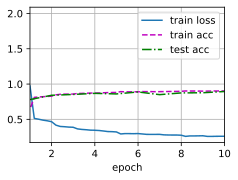

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### Results

loss 0.260, train acc 0.902, test acc 0.894

9294.8 examples/sec on cuda:0

## Now without batch norm to compare

In [ ]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5),nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    nn.Sigmoid(), nn.Linear(120, 84),nn.Sigmoid(),
                    nn.Linear(84, 10))

loss 0.312, train acc 0.884, test acc 0.870
19000.7 examples/sec on cuda:0


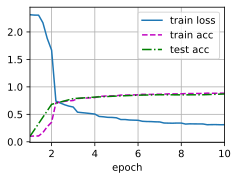

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### Results
loss 0.312, train acc 0.884, test acc 0.870

19000.7 examples/sec on cuda:0

## Bigger Batch Size Testing

Results indicate that a smaller batch size (<100) is better for batch norm models. The difference between the BN model with batch size=64 and standard model for LeNet was 24 whereas the difference for the BN model with batch size=256 and stand LeNet was only 4. 

### Batch Norm Model

loss 0.336, train acc 0.877, test acc 0.862
24098.1 examples/sec on cuda:0


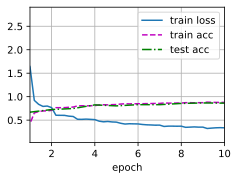

In [4]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,
                              kernel_size=5), BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))

lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Results

loss 0.336, train acc 0.877, test acc 0.862


24098.1 examples/sec on cuda:0

### Non Batch Norm

loss 0.308, train acc 0.886, test acc 0.858
18695.6 examples/sec on cuda:0


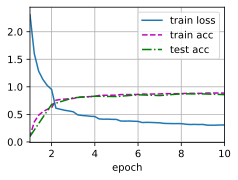

In [5]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5),nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    nn.Sigmoid(), nn.Linear(120, 84),nn.Sigmoid(),
                    nn.Linear(84, 10))

lr, num_epochs, batch_size = 1.0, 10, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Results

loss 0.308, train acc 0.886, test acc 0.858

18695.6 examples/sec on cuda:0

## Smaller Learning Rate ( < 1.0)
Ultimately did not work very well compared to a higher learning rate. The BN model with lr=0.3 converged quicker than the BN model with lr=1.0 however it converged to a lower test acc. By comparison, the non BN model also performed poorly with lr=0.3 compared to the non BN model with lr=1.0. Larger lr better for simpler models? Perhaps it is just due to taking longer to converge so it needs more epochs than the models with larger learning rates.

### Batch Norm Model

loss 0.276, train acc 0.898, test acc 0.881
9236.0 examples/sec on cuda:0


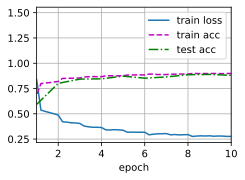

In [9]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,
                              kernel_size=5), BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))

lr, num_epochs, batch_size = 0.3, 10, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Results


### Non Batch Norm

loss 0.388, train acc 0.858, test acc 0.844
18639.3 examples/sec on cuda:0


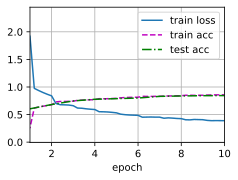

In [11]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5),nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    nn.Sigmoid(), nn.Linear(120, 84),nn.Sigmoid(),
                    nn.Linear(84, 10))

lr, num_epochs, batch_size = 0.3, 10, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### Smaller Learning Rate with More Epochs
Best accuracy so far. So smaller lr with more epochs gets higher accuracy than larger lr with less epochs although the increase for the BN model was only by 0.06 so it is not that much of an increase although still notable. This could possibly be due to having more time though. I'll run lr=1.0 with 20 epochs to check. For the non BN model however this model was just as bad as with 10 epochs.
#### BN Model

loss 0.225, train acc 0.917, test acc 0.900
9438.0 examples/sec on cuda:0


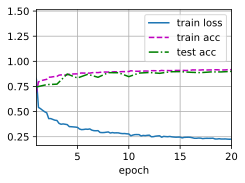

In [12]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,
                              kernel_size=5), BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))

lr, num_epochs, batch_size = 0.3, 20, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Results

loss 0.225, train acc 0.917, test acc 0.900

9438.0 examples/sec on cuda:0

#### Non BN Model

loss 0.393, train acc 0.856, test acc 0.844
18650.0 examples/sec on cuda:0


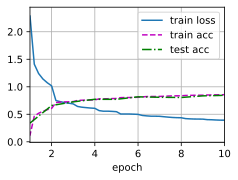

In [13]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5),nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    nn.Sigmoid(), nn.Linear(120, 84),nn.Sigmoid(),
                    nn.Linear(84, 10))

lr, num_epochs, batch_size = 0.3, 10, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Results

loss 0.393, train acc 0.856, test acc 0.844

18650.0 examples/sec on cuda:0

## Large LR with more epochs for BN (lr=1.0, epochs=20)
Testing to see if BN model with lr=0.3 and epochs=20 was due to the smaller lr or having more time to train.

#### Result
Less accurate than BN lr=0.3 epochs=20 so when the authors say a higher learning rate they don't mean especially high (Ioffe et al, 2015, p.5). This makes sense as in section 4.2.2 they state that they increased the Inception lr from 0.0015 to 0.0075 which is still extremely small compared to 0.3 although the Inception model is much more complex than LeNet (Ioffe et al, 2015, p. 7).

loss 0.210, train acc 0.921, test acc 0.894
9321.2 examples/sec on cuda:0


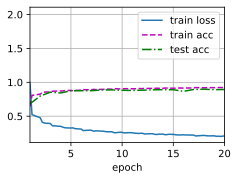

In [14]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,
                              kernel_size=5), BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))

lr, num_epochs, batch_size = 1.0, 20, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())